In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model

import loader
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32

data_dir = "data/communities"

In [2]:
## Load UCI Communities and Crime dataset

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_communities(data_dir, n_classes=5)
inputs_u_df = loader.load_communities(data_dir,
                                      n_classes=5,
                                      remove_sensitive_attr=True)[0]

display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,asian,black,hispanic,white
Target,,,,
"(-0.001, 0.2]",432,218,159,379
"(0.2, 0.4]",88,179,140,25
"(0.4, 0.6]",18,119,50,5
"(0.6, 0.8]",16,59,19,1
"(0.8, 1.0]",8,65,13,1


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000,  random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain);

In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = np.zeros((len(inputs_), n_groups * n_classes), dtype=np.float32)
probas_ay_u_[:, np.unique(labels_ay_pretrain)] = predictor_u_ay.predict_proba(
    inputs_u_)
probas_ay_u_ = probas_ay_u_.reshape(-1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

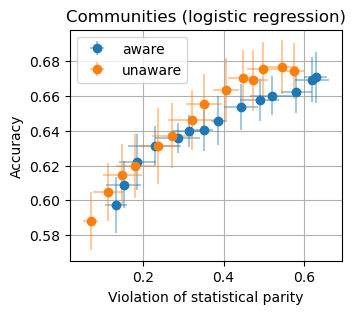

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.670569  0.014721  0.629017  0.028296
0.600  0.669231  0.012921  0.620131  0.042228
0.550  0.662207  0.012231  0.580662  0.038910
0.500  0.660201  0.011118  0.520777  0.054837
0.450  0.657525  0.011907  0.489495  0.047811
0.400  0.653846  0.013220  0.442981  0.042819
0.350  0.645819  0.013860  0.387042  0.017857
0.300  0.640134  0.011907  0.350066  0.023867
0.250  0.639799  0.009052  0.314901  0.044175
0.200  0.635786  0.008477  0.285389  0.056294
0.150  0.631104  0.011379  0.228619  0.065728
0.100  0.622074  0.016213  0.185533  0.045899
0.050  0.609030  0.013347  0.151829  0.043234
0.001  0.597324  0.016273  0.131500  0.027515

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.674247  0.016187  0.575348  0.024556
0.600  0.676589  0.015354  0.543874  0.039768
0.550  0.675251  0.015660  0.498285  0.041376
0.500  0.668896  0.017378  0.473953  0.035171
0.450  0.670234  0.016144  0.447520  0.037639
0.400  0.663211  0.018417  0.405373  0.032653
0.350  0.655184  0.017515  0.351770  0.045162
0.300  0.646154  0.017078  0.321202  0.058650
0.250  0.637124  0.018771  0.272390  0.051295
0.200  0.631438  0.021823  0.237463  0.048003
0.150  0.619732  0.018188  0.179875  0.046484
0.100  0.614716  0.017443  0.148524  0.049074
0.050  0.604682  0.016664  0.112315  0.037245
0.001  0.587960  0.016580  0.069224  0.019676

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
        0.05, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
        0.05, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Communities (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Gradient boosting decision tree

In [7]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6326
[LightGBM] [Info] Number of data points in the train set: 698, number of used features: 103
[LightGBM] [Info] Start training from score -0.539406
[LightGBM] [Info] Start training from score -1.537584
[LightGBM] [Info] Start training from score -2.299724
[LightGBM] [Info] Start training from score -2.937301
[LightGBM] [Info] Start training from score -3.021859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [8]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = np.zeros((len(inputs_), n_groups * n_classes), dtype=np.float32)
probas_ay_u_[:, np.unique(labels_ay_pretrain)] = predictor_u_ay.predict_proba(
    inputs_u_)
probas_ay_u_ = probas_ay_u_.reshape(-1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

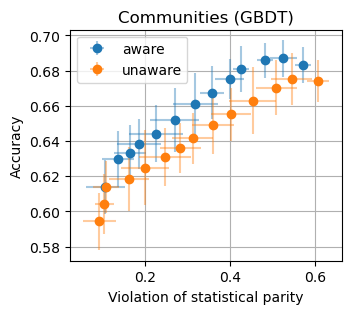

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.683278  0.010213  0.572662  0.018183
0.550  0.686957  0.010335  0.526163  0.032653
0.500  0.685953  0.009992  0.482198  0.018730
0.450  0.680936  0.013347  0.426538  0.018709
0.400  0.675251  0.011610  0.399205  0.034094
0.350  0.667559  0.015115  0.358460  0.028288
0.300  0.660870  0.017753  0.318377  0.052784
0.250  0.651839  0.018334  0.270293  0.057679
0.200  0.644147  0.016187  0.226352  0.063928
0.150  0.638127  0.014219  0.185361  0.052536
0.100  0.633445  0.015526  0.164009  0.038328
0.050  0.629766  0.015802  0.136048  0.038798
0.001  0.613712  0.015326  0.105830  0.045708

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.674247  0.011966  0.608303  0.025872
0.600  0.675251  0.014976  0.545447  0.047667
0.550  0.670234  0.015571  0.509712  0.048416
0.500  0.662876  0.019125  0.453666  0.055602
0.450  0.655184  0.015161  0.403120  0.046925
0.400  0.648829  0.016040  0.360904  0.049853
0.350  0.641472  0.014511  0.312586  0.048715
0.300  0.635786  0.014209  0.282717  0.048329
0.250  0.631104  0.016580  0.246449  0.061015
0.200  0.624749  0.021369  0.199833  0.057344
0.150  0.618395  0.018104  0.162167  0.047562
0.100  0.613712  0.014816  0.107753  0.030123
0.050  0.604348  0.016996  0.103732  0.022303
0.001  0.594314  0.016367  0.092168  0.039568

In [9]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05,
        0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
        0.05, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Communities (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)